# <center>Univariate Time Series Forecasting in COVID-19 Predictions</center>

### DATA 622 (Machine Learning): Final Project
### Atlanta Liu
### April 11, 2020

## <center>Introduction</center>

&nbsp;&nbsp; COVID-19 is spreading wide and fast across the globe and there is a pressing demand for data scientists to model and predict when the curve will 'flatten out'. While social distancing measures has helped to reduce the rate of infection, confirmed cases and death tolls are still on the rise in Canada (as of April 16, 2020). Creating an accurate model for this can be quite tricky as this strain of virus is quite new and many changes are made each day in how people are tested or who exactly should be tested. It can be difficult to account for these changes given our one week deadline, so this report will only focus on utilizing the data that is provided in the John Hopkins GitHub repository. 

&nbsp;&nbsp; The goal of this project is to predict the number of confirmed cases, deaths, and recovery for Canada (including individual provinces) in April 20, 21, and 22 by applying our understanding of machine learning methods. The content of this project can be broken down into several phases, including: data wrangling, data exploration, implementing various modelling techniques, as well as an evaluation section where our models are compared against the last 3 days available in the dataset. Since machine learning is largely empirical in practice, this project will compare multiple models against each other using mean-squared error as the primary evaluation metric. 





In [1]:
# Import Libraries for data wrangling, plotting, and pretty printing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pprint

# Sklearn Imports
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, RandomizedSearchCV
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Types of models we will be evaluating:
import xgboost as xgb #XGB_Regressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures


## Data Wrangling

&nbsp;&nbsp; The John-Hopkins GitHub repository provides three time-series datasets in a comma-separated values (CSV) format that will be used for this report. This includes counts from confirmed cases, deaths, and recovered. We can begin by loading in the dataset straight from the online repository, this lets us have access to the latest dates as it is continually updated on a daily basis. 

&nbsp;&nbsp; To initialize the data, we will be dropping unnecessary columns and removing a few locations that are not useful for our predictions (cruise ships and northern Canadian territories). Records begin on January 23 and a new entry is provided everyday thereafter. However, we see that it takes several weeks before the cases start to rise. 

In [2]:
# Loading in the latest data from github
url_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_recovered = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

# Reading csv into a pandas dataframe for all 3 datasets
# Dropping columns: longitude and latitude
confirmed = pd.read_csv(url_confirmed)
confirmed = confirmed.loc[confirmed['Country/Region'] == 'Canada'].drop(columns = ['Lat', 'Long', 'Country/Region'])


deaths = pd.read_csv(url_deaths)
deaths = deaths.loc[deaths['Country/Region'] == 'Canada'].drop(columns = ['Lat', 'Long', 'Country/Region'])

recovered = pd.read_csv(url_recovered)
recovered = recovered.loc[recovered['Country/Region'] == 'Canada'].drop(columns = ['Lat', 'Long', 'Province/State'])

In [3]:
# Let's drop a few provinces and states not used in our predictions for all 3 dataframes
# Also drop 'Recovered' row, as it has all 0s
drop_list = ['Grand Princess', 'Diamond Princess', 'Recovered']

confirmed = confirmed[~confirmed['Province/State'].isin(drop_list)]
deaths = deaths[~deaths['Province/State'].isin(drop_list)]

#Setting our index to the date and reformatting dataframe so that provinces are along the rows
confirmed = confirmed.set_index("Province/State").T
deaths = deaths.set_index("Province/State").T
recovered = recovered.set_index("Country/Region").T

## Data Exploration

&nbsp;&nbsp; We can start exploring the data by plotting the counts of confirmed cases, deaths, and recovery for each province in Canada and get a sense of what they look like. A log scale is used to help further separate the lines so each province is more distinct. For recovery rates, we only have Canada-wide number so it is plotted alone. Looking at the confirmed cases, we see that Ontario and BC have an extremely slow rise at first, and then it rapidly ascends. This might be due to the rapid changes in covid-19 testing procedures as time progressed. Interestingly, New Brunswick and Prince Edward Island do not appear to have any deaths. Our model will likely predict deaths for these provinces to be 0 since we are not taking into account time lag in univariate analysis. 

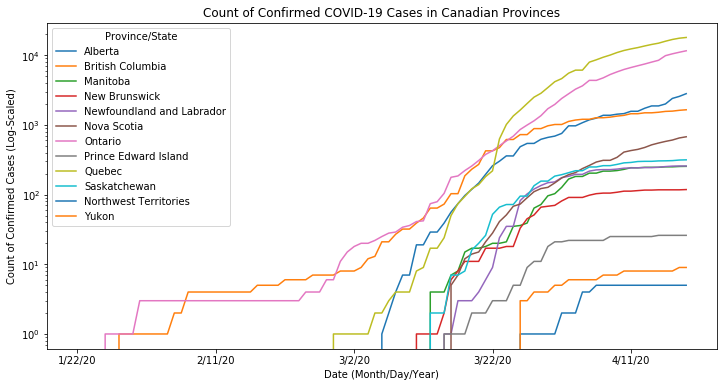

Province/State,Alberta,British Columbia,Manitoba,New Brunswick,Newfoundland and Labrador,Nova Scotia,Ontario,Prince Edward Island,Quebec,Saskatchewan,Northwest Territories,Yukon
4/15/20,1870,1517,246,117,247,549,8447,26,14860,304,5,8
4/16/20,1996,1561,250,117,252,579,9840,26,15857,305,5,8
4/17/20,2397,1575,250,117,256,606,10456,26,16798,307,5,8
4/18/20,2562,1618,253,117,257,649,11013,26,17521,313,5,9
4/19/20,2803,1647,254,118,257,675,11561,26,17950,315,5,9


In [4]:
# Displaying figure with a log-transformed y-scale to better visualize each province's condition
ax = confirmed.plot(figsize=(12,6))
ax.set_yscale('log')
ax.set_ylabel("Count of Confirmed Cases (Log-Scaled)")
ax.set_xlabel("Date (Month/Day/Year)")
ax.set_title("Count of Confirmed COVID-19 Cases in Canadian Provinces")
plt.show()

confirmed.tail()

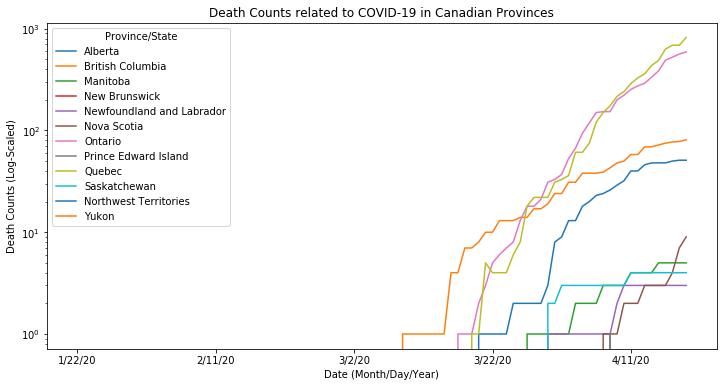

Province/State,Alberta,British Columbia,Manitoba,New Brunswick,Newfoundland and Labrador,Nova Scotia,Ontario,Prince Edward Island,Quebec,Saskatchewan,Northwest Territories,Yukon
4/15/20,48,72,5,0,3,3,385,0,487,4,0,0
4/16/20,48,75,5,0,3,3,490,0,630,4,0,0
4/17/20,50,77,5,0,3,4,524,0,688,4,0,0
4/18/20,51,78,5,0,3,7,564,0,688,4,0,0
4/19/20,51,81,5,0,3,9,591,0,820,4,0,0


In [5]:
# Displaying figure with a log-transformed y-scale to better visualize each province's condition
ax = deaths.plot(figsize=(12,6))
ax.set_yscale('log')
ax.set_ylabel("Death Counts (Log-Scaled)")
ax.set_xlabel("Date (Month/Day/Year)")
ax.set_title("Death Counts related to COVID-19 in Canadian Provinces")
plt.show()

deaths.tail()

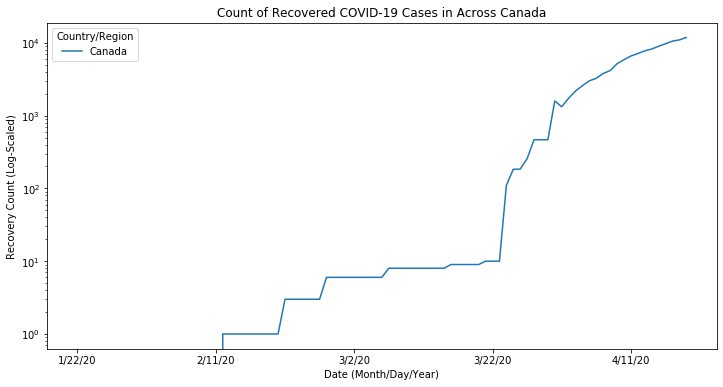

Country/Region,Canada
4/15/20,8966
4/16/20,9698
4/17/20,10545
4/18/20,10964
4/19/20,11847


In [6]:
# Displaying figure with a log-transformed y-scale to better visualize each province's condition
ax = recovered.plot(figsize=(12,6))
ax.set_yscale('log')
ax.set_ylabel("Recovery Count (Log-Scaled)")
ax.set_xlabel("Date (Month/Day/Year)")
ax.set_title("Count of Recovered COVID-19 Cases in Across Canada")
plt.show()

recovered.tail()

## Data Preprocessing

This next phase involves transforming the dataset so that we have our test and training data. A dataframe for each province will manually be extracted so that we can make a model for each of them. No two models will be the same since we will be hyper-parameter tuning each one of them individually to get the best results. We first begin by finding the first day where the recorded cases are above zero, since including 0 values will negatively impact the performance of our model. The provinces are transformed into series and stored into a list, where they will later be accessed to make evaluations and predictions.

In [7]:
# Splitting dataframe into different provinces for confirmed cases
Alberta = confirmed[confirmed['Alberta'] != 0]['Alberta'].reset_index(drop=True)
BritishColumbia = confirmed[confirmed['British Columbia'] != 0]['British Columbia'].reset_index(drop=True)
Manitoba = confirmed[confirmed['Manitoba'] != 0]['Manitoba'].reset_index(drop=True)

NewBrunswick = confirmed[confirmed['New Brunswick'] != 0]['New Brunswick'].reset_index(drop=True)
Newfoundland = confirmed[confirmed['Newfoundland and Labrador'] != 0]['Newfoundland and Labrador'].reset_index(drop=True)
NovaScotia = confirmed[confirmed['Nova Scotia'] != 0]['Nova Scotia'].reset_index(drop=True)

Ontario = confirmed[confirmed['Ontario'] != 0]['Ontario'].reset_index(drop=True)
PEI = confirmed[confirmed['Prince Edward Island'] != 0]['Prince Edward Island'].reset_index(drop=True)
Quebec = confirmed[confirmed['Quebec'] != 0]['Quebec'].reset_index(drop=True)
Saskatchewan = confirmed[confirmed['Saskatchewan'] != 0]['Saskatchewan'].reset_index(drop=True)

canada_confirmed = confirmed.loc[(confirmed != 0).any(1)]
canada_confirmed['Canada'] = canada_confirmed[list(canada_confirmed.columns)].sum(axis=1)
canada_confirmed = canada_confirmed['Canada'].reset_index(drop=True)

Province_list = [Alberta, BritishColumbia, Manitoba, NewBrunswick, Newfoundland, NovaScotia, 
                 Ontario, PEI, Quebec, Saskatchewan, canada_confirmed]

C:\Users\Atlan\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [8]:
# Splitting dataframe into different provinces for death counts
# I have excluded some provinces with 0 and included 0 in others
# 0s are included for provinces that do not have enough death counts above 0 to properly model them
# (Ie. New Brunswick, PEI, Newfoundland)

deaths_Alberta = deaths[deaths['Alberta'] != 0]['Alberta'].reset_index(drop=True)
deaths_BritishColumbia = deaths[deaths['British Columbia'] != 0]['British Columbia'].reset_index(drop=True)
deaths_Manitoba = deaths['Manitoba'].reset_index(drop=True)

deaths_NewBrunswick = deaths['New Brunswick'].reset_index(drop=True)
deaths_Newfoundland = deaths[deaths['Newfoundland and Labrador'] >= 0]['Newfoundland and Labrador'].reset_index(drop=True)
deaths_NovaScotia = deaths[deaths['Nova Scotia'] != 0]['Nova Scotia'].reset_index(drop=True)

deaths_Ontario = deaths[deaths['Ontario'] != 0]['Ontario'].reset_index(drop=True)
deaths_PEI = deaths['Prince Edward Island'].reset_index(drop=True)
deaths_Quebec = deaths[deaths['Quebec'] != 0]['Quebec'].reset_index(drop=True)
deaths_Saskatchewan = deaths[deaths['Saskatchewan'] != 0]['Saskatchewan'].reset_index(drop=True)

canada_deaths = deaths.loc[(deaths!=0).any(1)]
canada_deaths['Canada'] = canada_deaths[list(canada_deaths.columns)].sum(axis = 1)
canada_deaths = canada_deaths['Canada'].reset_index(drop=True)

Province_dlist = [deaths_Alberta, deaths_BritishColumbia, deaths_Manitoba, deaths_NewBrunswick,
                   deaths_Newfoundland, deaths_NovaScotia, deaths_Ontario, 
                  deaths_PEI, deaths_Quebec, deaths_Saskatchewan, canada_deaths]

C:\Users\Atlan\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
# Dataframe for recovered counts
recovered = recovered.loc[(recovered != 0).any(1)].reset_index(drop=True)

In [10]:
# We can test out each model using confirmed cases in Alberta as an example
# Splitting our data: X = days, y = counts
# Training = All days with a count > 0 (not including last 3 days), Testing = last 3 days
X_train = np.array(Alberta.index[:-3]).reshape(-1, 1)
X_test = np.array(Alberta.index[-3:]).reshape(-1, 1)
y_train = np.array(Alberta)[:-3]
y_test = np.array(Alberta)[-3:]

In [11]:
# Printing out the shapes of each split
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(42, 1)
(3, 1)
(42,)
(3,)


# <center> Univariate Time Series Regressions </center>

&nbsp;&nbsp; Simple regressions can be great tools to extrapolate data based on the line of best fit. We will be testing several regressions in this project since they are easy to interpret and can be compared against one another. The regressions that will be tested in this project include:

* XGBoost Regressor
* Gradient Boosting
* Support Vector Regression
* Linear Regression (w/ Polynomial Features)

&nbsp;&nbsp; The original goal was to begin with a simple univariate analysis and end up progressing towards more complex models. However, given the tight deadline, even hyper parameter tuning the regressions proved to be quite time consuming, as each province had to be manually tuned to find the best results. I later show that only two of the four tested regressions will be used for modelling the predictions, this includes SVR and Polynomial Regression since they showed the best performance (lowest MSE).

&nbsp;&nbsp; There are many other regressions that I could have also added to this notebook, however, the model already appeared to be running quite well with SVR and polynomial regression so I stuck with those two. I purposefully chose to avoid regression trees, ridge regression, lasso regression, and elastic net regression because they were not well suited for this type of problem. While regression trees can model non-linear relationships fairly well, they are prone to overfitting especially on simple data such as this. Ridge, Lasso, and Elastic-Net regressions only work for modelling linear relations so they were out of the equation. 

## XGBoost Regressor

XGBoost stands for extreme gradient boosting, it is a type of ensemble method that is known for having a high execution speed (comparing to other boosts) and offering great performance. It does so by building a decision tree that reduces the residual in each sequence to minimize training loss. **[1]**

Looking at XGBoost Regressor, we did a quick randomizedsearchCV from a wide range of parameters to see if it was a viable approach. Looking at the graph, we see that this model clearly suffers from overfitting as the line of best fit moves directly from one data point to the other rather than in a smooth line. Comparing the MSE values (SVR = 23735, XGBRegressor = 97868), we see that our initial SVR is a much better model than this. Even after adding a parameter for early stopping, we see that this doesn't help the model much. 

Why doesn't XGBoost work well here? Well, our model is extremely simple to begin with. We are only doing a univariate analysis so having a system that optimizes the residuals on only one parameter can easily lead to overfitting. Our model is not complex enough to benefit from regularization (alpha) either. XGBoost might be a better choice for larger and multi-featured datasets. Some tutorials on Kaggle show that XGBoost can be a decent predictor for time series forecasting given multiple time variables (week, month, year, weather, and lag) **[2]**.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'reg_lambda': 0.1, 'reg_alpha': 0.0, 'n_estimators': 94, 'max_depth': 3, 'learning_rate': 0.0555}
[0]	validation_0-rmse:2495.97363
Will train until validation_0-rmse hasn't improved in 10 rounds.
[10]	validation_0-rmse:1755.95019
[20]	validation_0-rmse:1312.45618
[30]	validation_0-rmse:1048.68628
[40]	validation_0-rmse:880.77539
[50]	validation_0-rmse:775.30560
[60]	validation_0-rmse:710.00159
[70]	validation_0-rmse:671.24915
[80]	validation_0-rmse:648.22565
[90]	validation_0-rmse:634.53351
[93]	validation_0-rmse:631.63190


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.4s finished


XGB Regressor Mean Squared Error = 398958.83974772197
XGB Regressor Mean Absolute Error = 609.2333577473959


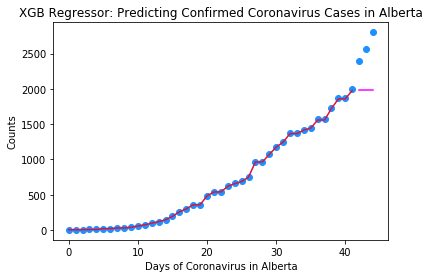

In [12]:
# A parameter for random search in XGBoost Regressor based on assignment 5
max_depth = list(range(1, 10, 1))
learning_rate = [i/10000 for i in range(1, 1000, 1)] # Learning rate range: 0.0001 to 1
n_estimators = list(range(0, 101, 1))
reg_alpha = [i/10 for i in range(0, 11, 1)]
reg_lambda = [i/10 for i in range(0, 11, 1)]
eval_set = [(X_test, y_test)]

params = [{'max_depth': max_depth,
          'learning_rate': learning_rate,
          'n_estimators': n_estimators,
          'reg_alpha': reg_alpha,
          'reg_lambda': reg_lambda}]

gs = RandomizedSearchCV(xgb.XGBRegressor(), params, cv=5, 
                  scoring = 'neg_mean_squared_error', 
                  verbose = True, random_state = 0)
gs.fit(X_train, y_train)
print(gs.best_params_)

# Fitting XGB regressor 
xgb_model = gs.best_estimator_
xgb_model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=eval_set, verbose=10)

xgb_ypred_train = xgb_model.predict(X_train) #For plotting purposes
xgb_ypred = xgb_model.predict(X_test)


# Plot base confirmed counts in circles
plt.scatter(x = Alberta.index, y = Alberta, color = 'dodgerblue')

plt.plot(X_train, xgb_ypred_train, 'crimson') # Plot training fit
plt.plot(X_test, xgb_ypred, 'fuchsia') # Plot testing fit

# Labeling plots
plt.xlabel("Days of Coronavirus in Alberta")
plt.ylabel("Counts")
plt.title("XGB Regressor: Predicting Confirmed Coronavirus Cases in Alberta")

# Print out results
print("XGB Regressor Mean Squared Error =", metrics.mean_squared_error(y_test, xgb_ypred))
print("XGB Regressor Mean Absolute Error =", metrics.mean_absolute_error(y_test, xgb_ypred))

## Support Vector Regression (SVR)

&nbsp;&nbsp; Support vector regression works similarly to support vector machine in classification. It has a hyperplane, but instead of maximizing the distance between each class, the hyperplane attempts to minimize the error term (ordinary least squares method) and controlling the margins around the hyperplane. This results in the line of best fit by having the hyperplane as close as possible to the data points. A kernel trick can be applied to help it map polynomial functions as shown in our grid search below.

&nbsp;&nbsp; Several parameters are added here to help us find the best SVR model. I searched through all the different **kernel** types and found that only 'linear' and 'poly' were across all 3 datasets. The **degree** parameter is only applied in 'poly' kernel to see what higher order it should be mapped to. The value of **epsilon** describes how wide the margins are for the hyperplane. A wider margin means that the model can ignore a broader range of errors. Lastly, the parameter **'C'** represents the cost function, or how much our model should penalize errors within our margins. A higher cost means that our model will penalize errors within our margins more. Looking at our folds for cross validation, **cv=10** is used here since it returns the best results.

&nbsp;&nbsp; Looking at the MSE from our plot below, we see that the results are far better than our previous two regressions. This model will be used and tested across all the provinces to see where it works best.

In [13]:
# Normally, our random search should encompass a wider range of parameters. But I reduced it here to save time as it shows
# the same results even running it multiple times.
param_grid = [{'kernel': ['linear', 'poly'], 'degree': [0, 1, 2, 3],
               'epsilon': np.arange(0,1,0.1), 'C':  [1, 10, 100]}]
gs = RandomizedSearchCV(SVR(), param_grid, cv=10, scoring = 'neg_mean_squared_error')
gs.fit(X_train, y_train)
print(gs.best_params_)

{'kernel': 'poly', 'epsilon': 0.0, 'degree': 2, 'C': 10}


In [14]:
# Lets use the best estimators from our SVR grid search and apply it to our model
final_model = gs.best_estimator_
final_model.fit(X_train, y_train)
SVR_ytrain_pred = final_model.predict(X_train) #For plotting purposes
SVR_ytest_pred = final_model.predict(X_test)

SVR Mean Squared Error = 154348.01478632182
SVR Mean Absolute Error = 384.0013951426425


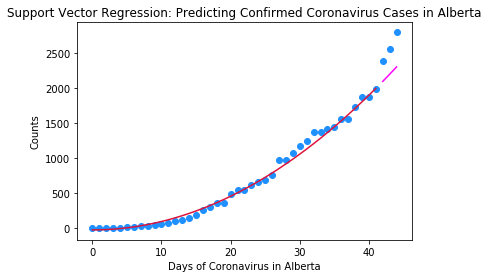

In [15]:
#Plot base confirmed counts in circles
plt.scatter(x = Alberta.index, y = Alberta, color = 'dodgerblue')

#Plot training fit
plt.plot(X_train, SVR_ytrain_pred, 'crimson')

#Plot testing fit
plt.plot(X_test, SVR_ytest_pred, 'fuchsia')

plt.xlabel("Days of Coronavirus in Alberta")
plt.ylabel("Counts")
plt.title("Support Vector Regression: Predicting Confirmed Coronavirus Cases in Alberta")

# Print out results
print("SVR Mean Squared Error =", metrics.mean_squared_error(y_test, SVR_ytest_pred))
print("SVR Mean Absolute Error =", metrics.mean_absolute_error(y_test, SVR_ytest_pred))

## Polynomial Regression

&nbsp;&nbsp; Polynomial regression is perhaps the most simplistic regression there is to model higher order data that is continuous. Sklearn provides a **PolynomialFeatures()** function that allows us to take higher orders into account, even though we are using the LinearRegression() method. Comparing the MSE values below with our SVR, we see that polynomial regression can perform better than (or just as well) as SVR. The degrees were manually tuned here, but I will include a loop to find the best degree based on the MSE up next when we begin iterating through all the provinces to find out which model performs best in each location.

Mean Squared Error = 105972.48102604404
Mean Absolute Error =  322.95573287794315


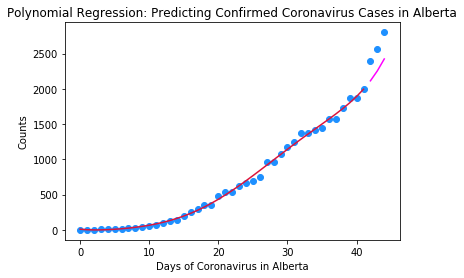

In [16]:
# Need to transform our X_data so that it can take polynomials
poly_features= PolynomialFeatures(degree=6)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.fit_transform(X_test)

# Applying model and evaluating data
reg = linear_model.LinearRegression()
reg.fit(X_train_poly, y_train)
y_train_pred = reg.predict(X_train_poly)
y_test_pred = reg.predict(X_test_poly)

# Plot base confirmed counts in circles
plt.scatter(x = Alberta.index, y = Alberta, color = 'dodgerblue')
plt.plot(X_train, y_train_pred, 'crimson') #Plot training fit
plt.plot(X_test, y_test_pred, 'fuchsia') #Plot testing fit

# Show labels
plt.xlabel("Days of Coronavirus in Alberta")
plt.ylabel("Counts")
plt.title("Polynomial Regression: Predicting Confirmed Coronavirus Cases in Alberta")

print("Mean Squared Error =", metrics.mean_squared_error(y_test, y_test_pred))
print("Mean Absolute Error = ", metrics.mean_absolute_error(y_test, y_test_pred))

## <center>Model Selection For Each Province</center>

&nbsp;&nbsp; Even though we have only shown SVR and Polynomial Regression on one province and only looking at confirmed cases, we have a general idea even a simple regression can work fairly well for this type of prediction problem. Assuming that both types of regression model runs somewhat similarly across other provinces, this next section will look at what model runs best for each province. A 'for' loop will be used to iterate through all of the provinces in Canada so that we can directly compare SVR and Polynomial Regression in each province. Both confirmed cases and deaths for each province will be examined.

&nbsp;&nbsp; Originally, I was planning to do an intensive grid search, but it turns out that SVR did not work as well as I thought on April 18. So I then focused my attention on Polynomial Regression and left this section with a randomized search just to show it in action. As of April 19 (6:00PM), SVR shows improvement in some provinces but I'm deciding to just run everything using polynomial regression. We can see the comparison in MSE below.

### Confirmed Cases (SVR vs. Polynomial Regression)

Alberta SVR Mean Squared Error = 135339.79685525966
Alberta SVR Mean Absolute Error = 358.6773586522113
Alberta Parameters = {'kernel': 'poly', 'epsilon': 0.9, 'degree': 2, 'C': 1000} 

British Columbia SVR Mean Squared Error = 75151.95274799985
British Columbia SVR Mean Absolute Error = 272.61073794993814
British Columbia Parameters = {'kernel': 'poly', 'epsilon': 0.9, 'degree': 3, 'C': 100} 

Manitoba SVR Mean Squared Error = 1648.5638333442068
Manitoba SVR Mean Absolute Error = 40.17666666675791
Manitoba Parameters = {'kernel': 'linear', 'epsilon': 0.71, 'degree': 4, 'C': 1000} 

New Brunswick SVR Mean Squared Error = 556.0770551429806
New Brunswick SVR Mean Absolute Error = 23.3977777777548
New Brunswick Parameters = {'kernel': 'linear', 'epsilon': 0.14, 'degree': 5, 'C': 100} 

Newfoundland and Labrador SVR Mean Squared Error = 3781.5700296250216
Newfoundland and Labrador SVR Mean Absolute Error = 61.019999999964114
Newfoundland and Labrador Parameters = {'kernel': 'linear', 'epsi

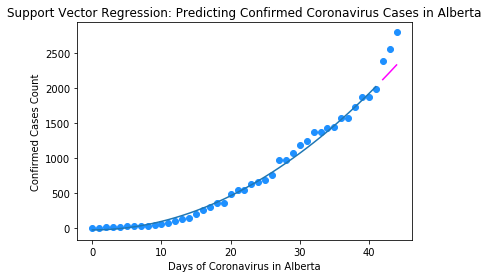

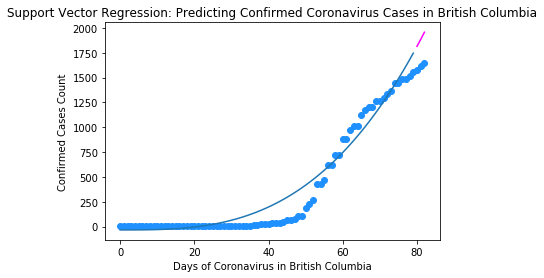

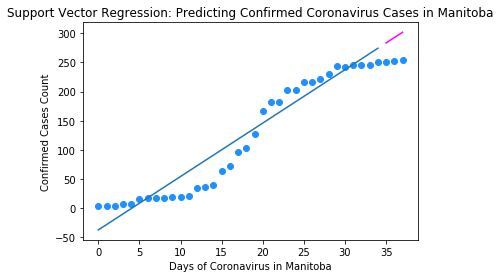

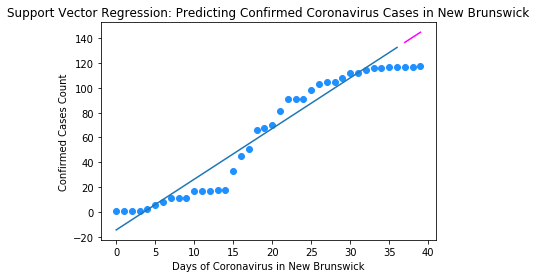

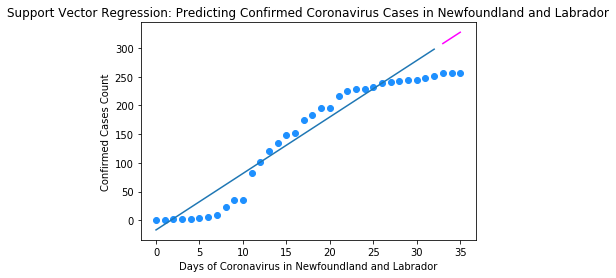

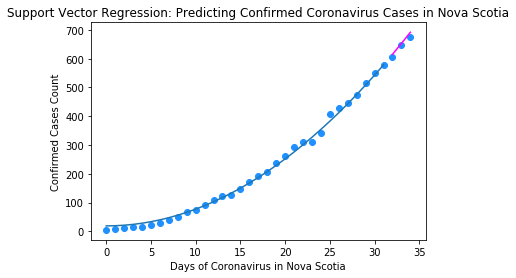

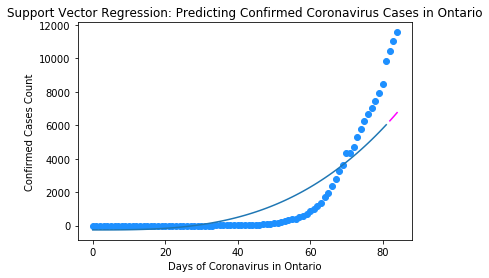

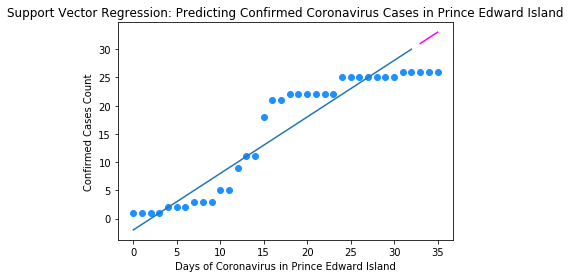

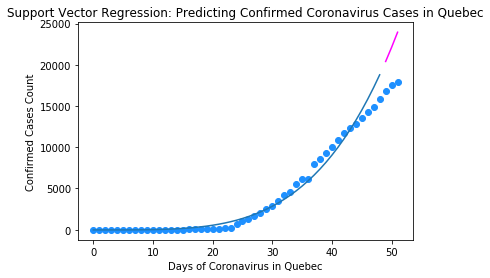

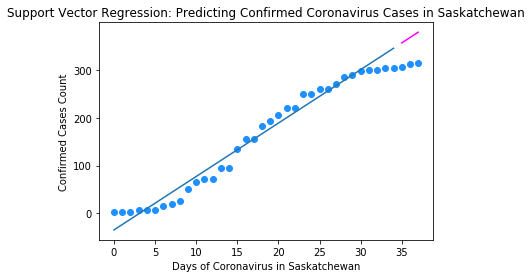

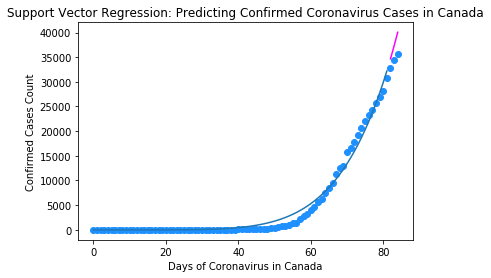

In [17]:
# Running this should take a few minutes, since we are doing a grid search for every province through SVR
# Record the MSE for each province in a dictionary for later comparison with PolyRegression
# The variable 'name' will help us print the name of the province
Province_SVR_MSE = {}
name = 0

# Iterate through all the provinces for confirmed cases
for province in Province_list:

    # Split data
    X_train = np.array(province.index[:-3]).reshape(-1, 1)
    X_test = np.array(province.index[-3:]).reshape(-1, 1)
    y_train = np.array(province)[:-3]
    y_test = np.array(province)[-3:]

    # Apply a random search for every province
    param_grid = [{'kernel': ['linear', 'poly'], 'degree': [0, 1, 2, 3, 4, 5, 6],
               'epsilon': np.arange(0, 1, 0.01), 'C':  [1, 10, 100, 1000]}]
    gs = RandomizedSearchCV(SVR(), param_grid, cv=10, scoring = 'neg_mean_squared_error', n_jobs = -1)
    gs.fit(X_train, y_train)

    # Apply Model
    final_model = gs.best_estimator_
    final_model.fit(X_train, y_train)
    SVR_ytrain_pred = final_model.predict(X_train) #For plotting purposes
    SVR_ytest_pred = final_model.predict(X_test)

    # Print prediction results
    print(confirmed.columns[name], "SVR Mean Squared Error =", metrics.mean_squared_error(y_test, SVR_ytest_pred))
    print(confirmed.columns[name], "SVR Mean Absolute Error =", metrics.mean_absolute_error(y_test, SVR_ytest_pred))
    print(confirmed.columns[name], "Parameters =", gs.best_params_, '\n')

    # Plot a figure
    plt.figure()
    plt.scatter(x = province.index, y = province, color = 'dodgerblue')
    plt.plot(X_train, SVR_ytrain_pred)
    plt.plot(X_test, SVR_ytest_pred, 'fuchsia')

    # Label the plots
    plt.xlabel("Days of Coronavirus in " + Province_list[name].name)
    plt.ylabel("Confirmed Cases Count")
    plt.title("Support Vector Regression: Predicting Confirmed Coronavirus Cases in " + Province_list[name].name)
    
    # Record {name of province: MSE}
    Province_SVR_MSE.update({Province_list[name].name: metrics.mean_squared_error(y_test, SVR_ytest_pred)})

    # Prepare to print next province name
    name += 1

plt.show()    

## Linear Regression (w/ Polynomial Features)

In [18]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures

poly_features= PolynomialFeatures(degree=6)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.fit_transform(X_test)

reg = linear_model.LinearRegression()
reg.fit(X_train_poly, y_train)
y_train_pred = reg.predict(X_train_poly)
y_test_pred = reg.predict(X_test_poly)

In [19]:
# Code is adapted from [3] https://stackoverflow.com/questions/47442102/how-to-find-the-best-degree-of-polynomials

# Create a dictionary to hold MSE for each province
# Create a list to hold best degrees for each province
Province_Poly_MSE = {}
confirmed_degrees = []
name = 0

for province in Province_list:
    # Split data for each province
    X_train = np.array(province.index[:-3]).reshape(-1, 1)
    X_test = np.array(province.index[-3:]).reshape(-1, 1)
    y_train = np.array(province)[:-3]
    y_test = np.array(province)[-3:]
    
    # Finding Best Polynomial Degree
    mses = []
    degrees = np.arange(1, 10)
    min_mse, min_deg = 1e10, 0

    for deg in degrees:
        # Polynomializing X_data
        poly_features = PolynomialFeatures(degree=deg)
        x_poly_train = poly_features.fit_transform(X_train)
        x_poly_test = poly_features.fit_transform(X_test)
        
        # Linear regression
        poly_reg = linear_model.LinearRegression()
        poly_reg.fit(x_poly_train, y_train)

        # Compare with test data
        y_train_pred = poly_reg.predict(x_poly_train)
        y_test_pred = poly_reg.predict(x_poly_test)
        
        # Evaluation
        poly_mse = metrics.mean_squared_error(y_test, y_test_pred)
        mses.append(poly_mse)

        # Cross-validation of degree
        if min_mse > poly_mse:
            min_mse = poly_mse
            min_deg = deg
            
        
    # Print results and update dictionary
    print(Province_list[name].name, '- Best degree is {} with MSE {}'.format(min_deg, min_mse))
    Province_Poly_MSE.update({Province_list[name].name: min_mse})
    confirmed_degrees.append(min_deg)
    name += 1
    

Alberta - Best degree is 7 with MSE 23273.306200628558
British Columbia - Best degree is 4 with MSE 769.3728356410248
Manitoba - Best degree is 3 with MSE 494.15203629001513
New Brunswick - Best degree is 8 with MSE 31.268148382653493
Newfoundland and Labrador - Best degree is 4 with MSE 35.401019175787845
Nova Scotia - Best degree is 7 with MSE 22.639428325915066
Ontario - Best degree is 5 with MSE 23553.322584077174
Prince Edward Island - Best degree is 4 with MSE 0.7935780305572472
Quebec - Best degree is 7 with MSE 148035.7599101458
Saskatchewan - Best degree is 4 with MSE 92.77086482183743
Canada - Best degree is 5 with MSE 57438.117450841826


In [20]:
# Print out scores for both categores and find out which model works best for each province
print("SVR MSE scores for confirmed cases \n")
pprint.pprint(Province_SVR_MSE)

print('\n')

print("Polynomial Regression scores for confirmed cases \n")
pprint.pprint(Province_Poly_MSE)

SVR MSE scores for confirmed cases 

{'Alberta': 135339.79685525966,
 'British Columbia': 75151.95274799985,
 'Canada': 10635738.103262551,
 'Manitoba': 1648.5638333442068,
 'New Brunswick': 556.0770551429806,
 'Newfoundland and Labrador': 3781.5700296250216,
 'Nova Scotia': 128.72339061669425,
 'Ontario': 20325751.737387527,
 'Prince Edward Island': 36.66666666667724,
 'Quebec': 23413880.087127596,
 'Saskatchewan': 3217.762374149657}


Polynomial Regression scores for confirmed cases 

{'Alberta': 23273.306200628558,
 'British Columbia': 769.3728356410248,
 'Canada': 57438.117450841826,
 'Manitoba': 494.15203629001513,
 'New Brunswick': 31.268148382653493,
 'Newfoundland and Labrador': 35.401019175787845,
 'Nova Scotia': 22.639428325915066,
 'Ontario': 23553.322584077174,
 'Prince Edward Island': 0.7935780305572472,
 'Quebec': 148035.7599101458,
 'Saskatchewan': 92.77086482183743}


## COVID-19 Death Counts by Province (SVR vs Polynomial Regression)

In this next section, we will be testing both SVR and polynomial regression on the death counts to see if their results are similar in this dataset. 

Alberta SVR Mean Squared Error = 50.10624999226698
Alberta SVR Mean Absolute Error = 6.454638581702274
Alberta Parameters = {'kernel': 'rbf', 'epsilon': 0.54, 'degree': 6, 'C': 100} 

British Columbia SVR Mean Squared Error = 5.366077813262514
British Columbia SVR Mean Absolute Error = 2.061929810551135
British Columbia Parameters = {'kernel': 'poly', 'epsilon': 0.17, 'degree': 2, 'C': 10} 

Manitoba SVR Mean Squared Error = 0.0531059988074681
Manitoba SVR Mean Absolute Error = 0.18557006836786213
Manitoba Parameters = {'kernel': 'rbf', 'epsilon': 0.16, 'degree': 4, 'C': 10} 

New Brunswick SVR Mean Squared Error = 0.0
New Brunswick SVR Mean Absolute Error = 0.0
New Brunswick Parameters = {'kernel': 'rbf', 'epsilon': 0.49, 'degree': 1, 'C': 1} 

Newfoundland and Labrador SVR Mean Squared Error = 0.3736002759203672
Newfoundland and Labrador SVR Mean Absolute Error = 0.606357679533926
Newfoundland and Labrador Parameters = {'kernel': 'poly', 'epsilon': 0.34, 'degree': 3, 'C': 100} 

Nova

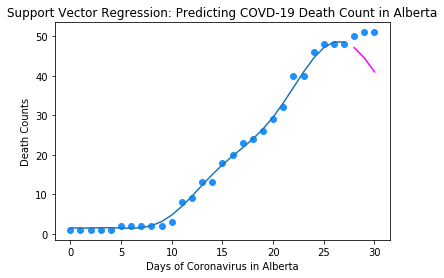

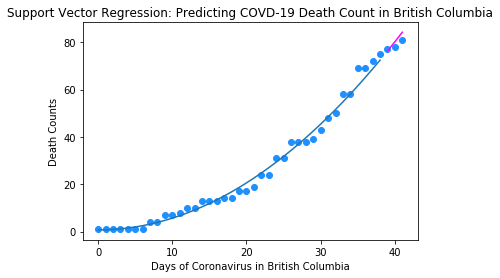

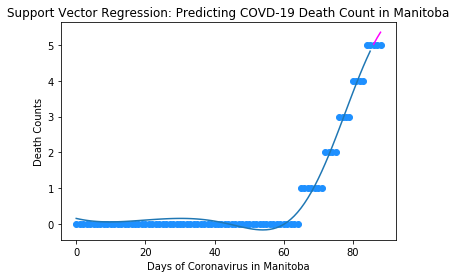

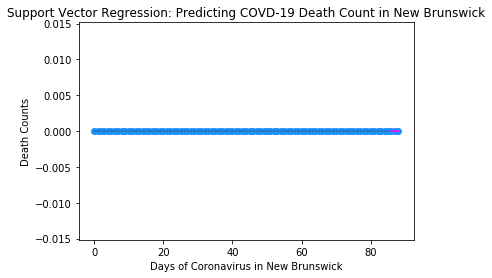

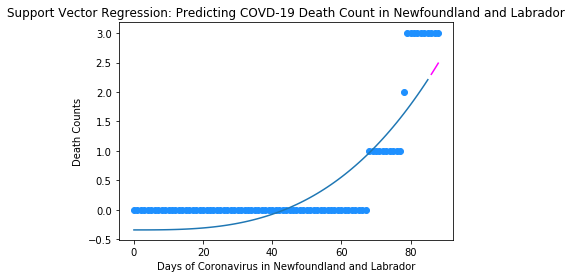

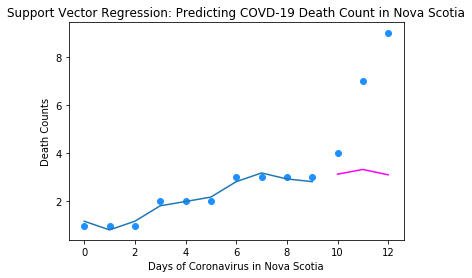

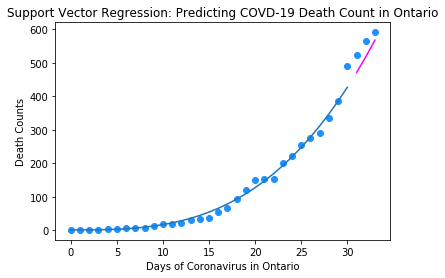

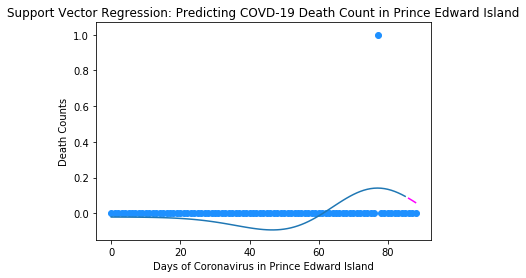

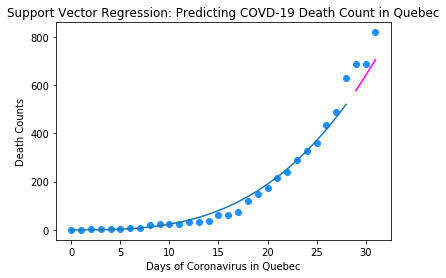

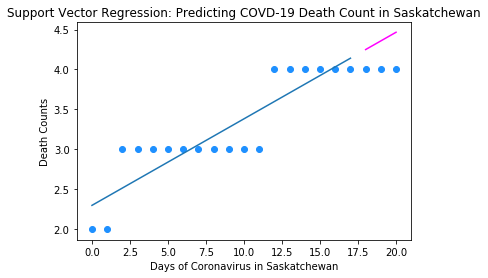

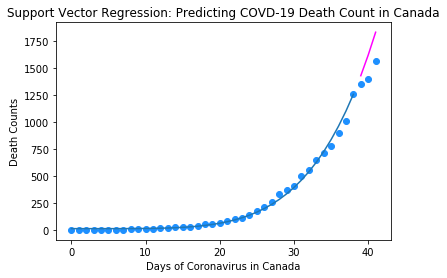

In [21]:
# Support Vector Regression for Deaths Across Canada Provinces

# Creating a container to hold MSE values 
Death_SVR_MSE = {}

name = 0
for province in Province_dlist:
    
    # Split data
    X_train = np.array(province.index[:-3]).reshape(-1, 1)
    X_test = np.array(province.index[-3:]).reshape(-1, 1)
    y_train = np.array(province)[:-3]
    y_test = np.array(province)[-3:]
    
    # Lets apply a grid search:
    # Note that degree here is much smaller, since the data for death counts is much more sparse
    param_grid = [{'kernel': ['linear', 'poly', 'rbf'], 'degree': [0, 1, 2, 3, 4, 5, 6],
               'epsilon': np.arange(0, 1, 0.01), 'C':  [1, 10, 100, 1000]}]
    gs = RandomizedSearchCV(SVR(), param_grid, cv=5, scoring = 'neg_mean_squared_error', n_jobs = -1)
    gs.fit(X_train, y_train)
    
    # Apply Model
    final_model = gs.best_estimator_
    final_model.fit(X_train, y_train)
    SVR_ytrain_pred = final_model.predict(X_train) #For plotting purposes
    SVR_ytest_pred = final_model.predict(X_test)
    
    # Print prediction results
    print(Province_dlist[name].name, "SVR Mean Squared Error =", metrics.mean_squared_error(y_test, SVR_ytest_pred))
    print(Province_dlist[name].name, "SVR Mean Absolute Error =", metrics.mean_absolute_error(y_test, SVR_ytest_pred))
    print(Province_dlist[name].name, "Parameters =", gs.best_params_, '\n')
    
    # Plot a figure
    plt.figure()
    plt.scatter(x = province.index, y = province, color = 'dodgerblue')
    plt.plot(X_train, SVR_ytrain_pred)
    plt.plot(X_test, SVR_ytest_pred, 'fuchsia')
    
    # Label the plots
    plt.xlabel("Days of Coronavirus in " + Province_dlist[name].name)
    plt.ylabel("Death Counts")
    plt.title("Support Vector Regression: Predicting COVD-19 Death Count in " + Province_dlist[name].name)
    
    # Prepare to print next province name and updating dictionary
    Death_SVR_MSE.update({Province_dlist[name].name: metrics.mean_absolute_error(y_test, SVR_ytest_pred)})
    name += 1
    

plt.show()    

In [22]:
# Running polynomial regression to find best degree in death counts for all provinces
death_degrees = []
Death_Poly_MSE = {}

name = 0
for province in Province_dlist:
    # Split data for each province
    X_train = np.array(province.index[:-3]).reshape(-1, 1)
    X_test = np.array(province.index[-3:]).reshape(-1, 1)
    y_train = np.array(province)[:-3]
    y_test = np.array(province)[-3:]
    
    # Finding Best Polynomial Degree
    mses = []
    degrees = np.arange(1, 10)
    min_mse, min_deg = 1e10, 0

    for deg in degrees:
        # Polynomializing X_data
        poly_features = PolynomialFeatures(degree=deg)
        x_poly_train = poly_features.fit_transform(X_train)
        x_poly_test = poly_features.fit_transform(X_test)
        
        # Linear regression
        poly_reg = linear_model.LinearRegression()
        poly_reg.fit(x_poly_train, y_train)

        # Compare with test data
        y_train_pred = poly_reg.predict(x_poly_train)
        y_test_pred = poly_reg.predict(x_poly_test)
        
        # Evaluation
        poly_mse = metrics.mean_squared_error(y_test, y_test_pred)
        mses.append(poly_mse)

        # Cross-validation of degree
        if min_mse > poly_mse:
            min_mse = poly_mse
            min_deg = deg
        
    # Plot and present results
    print(Province_dlist[name].name, '- Best degree is {} with MSE {}'.format(min_deg, min_mse))
    death_degrees.append(min_deg)
    Death_Poly_MSE.update({Province_dlist[name].name: min_mse})
    
    name += 1
    

Alberta - Best degree is 4 with MSE 0.3999202383207674
British Columbia - Best degree is 5 with MSE 13.824628669542633
Manitoba - Best degree is 7 with MSE 0.0639702370764194
New Brunswick - Best degree is 1 with MSE 0.0
Newfoundland and Labrador - Best degree is 7 with MSE 0.03659751347196486
Nova Scotia - Best degree is 1 with MSE 11.168815426997242
Ontario - Best degree is 3 with MSE 408.2980717857331
Prince Edward Island - Best degree is 1 with MSE 0.001648338394222981
Quebec - Best degree is 3 with MSE 2049.353175805975
Saskatchewan - Best degree is 2 with MSE 0.11417034360319474
Canada - Best degree is 3 with MSE 1709.1739123770767


In [23]:
# Comparing SVR with Polynomial Regression in death counts
print("SVR MSE scores for confirmed cases \n")
pprint.pprint(Death_SVR_MSE)

print('\n')

print("Polynomial Regression scores for confirmed cases \n")
pprint.pprint(Death_Poly_MSE)

SVR MSE scores for confirmed cases 

{'Alberta': 6.454638581702274,
 'British Columbia': 2.061929810551135,
 'Canada': 187.80947029017838,
 'Manitoba': 0.18557006836786213,
 'New Brunswick': 0.0,
 'Newfoundland and Labrador': 0.606357679533926,
 'Nova Scotia': 3.4802930261345337,
 'Ontario': 41.04165571634659,
 'Prince Edward Island': 0.07162376118574743,
 'Quebec': 90.26555495135479,
 'Saskatchewan': 0.35714285714286476}


Polynomial Regression scores for confirmed cases 

{'Alberta': 0.3999202383207674,
 'British Columbia': 13.824628669542633,
 'Canada': 1709.1739123770767,
 'Manitoba': 0.0639702370764194,
 'New Brunswick': 0.0,
 'Newfoundland and Labrador': 0.03659751347196486,
 'Nova Scotia': 11.168815426997242,
 'Ontario': 408.2980717857331,
 'Prince Edward Island': 0.001648338394222981,
 'Quebec': 2049.353175805975,
 'Saskatchewan': 0.11417034360319474}


### As of April 16, 2020:

* SVR works better for predicting confirmed and death counts in Alberta, Ontario, and Canada total\
Polynomial regresion should be used for all other provinces

### As of April 18, 2020: 

* SVR does NOT work better in any situation for confirmed cases or deaths when compared to polynomial regression \
Our final model will not include SVR, rather only polynomial regression will be used for all predictive modelling

### As of April 19, 2020:

* SVR shows some improvement in performance for predicting deaths in Ontario and Quebec over polynomial regression. However, for simplicity sake we will still be using polynomial regression since it works in the vast majority of other provinces

# <center> Making 3-Day Predictions (April 20-22) </center>

### Predicting Next 3 Days for Confirmed Cases (SVR - Unused Section)

Code here is left commented out, but it can be brought back to make predictions another day.

In [24]:
# # Unused code, as SVR is no longer a good model
# # Begin iterating through all provinces for SVR

# def SVR_prediction(Provincelist):
#     global predictions
#     predictions = {}
#     name = 0
#     for province in Provincelist:

#         #Splitting data: X = dates, y = counts
#         X_train = np.array(province.index).reshape(-1,1)
#         X_test = np.array(range(province.index.max(), province.index.max() + 3)).reshape(-1,1) # Next 3 days
#         y_train = np.array(province)
#         # No y_test will be available for comparison

#         # Lets try to apply a grid search for each province, only poly and linear are used
#         param_grid = [{'kernel': ['linear', 'poly'], 'degree': [0, 1, 2, 3, 4, 5, 6],
#                    'epsilon': np.arange(0, 1, 0.1), 'C':  [1, 10, 100]}]
#         gs = GridSearchCV(SVR(), param_grid, cv=10, scoring = 'neg_mean_squared_error', n_jobs = -1)
#         gs.fit(X_train, y_train)

#         # Apply Model
#         final_model = gs.best_estimator_
#         final_model.fit(X_train, y_train)
#         SVR_ytrain_pred = final_model.predict(X_train) #For plotting purposes
#         SVR_ytest_pred = final_model.predict(X_test)

#         # Print prediction results
#         print(Provincelist[name].name, "SVR 3-day Prediction =", SVR_ytest_pred)
#         print(Provincelist[name].name, "SVR Parameters =", gs.best_params_, '\n')

#         # Plot a figure
#         plt.figure()
#         plt.scatter(x = province.index, y = province, color = 'dodgerblue')
#         plt.plot(X_train, SVR_ytrain_pred, 'crimson')
#         plt.plot(X_test, SVR_ytest_pred, 'fuchsia')

#         # Label the plots
#         plt.xlabel("Days of Coronavirus in " + Provincelist[name].name)
#         plt.ylabel("Counts")
#         plt.title("Support Vector Regression: Predicting Confirmed Coronavirus Cases in " + Provincelist[name].name)

#         predictions.update({Provincelist[name].name: np.around(SVR_ytest_pred, 0)})
#         # Prepare to print next province name
#         name += 1

#     plt.show()
#     return predictions

In [25]:
# Confirmed_SVR_Provinces = [Alberta, Ontario]
# SVR_prediction(Confirmed_SVR_Provinces)
# confirmed_predicts.update(predictions)

### Predicting Next 3 Days for Confirmed Cases (Polynomial Regression) 

In [26]:
# Creating a function to help us predict the counts, given a list of provinces
def PolyReg_prediction(Provincelist, degreelist):
    
    # Start by initializing a dictionary to hold 3-day prediction values
    # name will be used to keep track of what province we are working with
    global predictions
    predictions = {}
    name = 0
    
    # Iterate through every province in our list
    for province in Provincelist:

        #Splitting data: X = dates, y = counts
        X_train = np.array(province.index).reshape(-1,1)
        X_test = np.array(range(province.index.max(), province.index.max() + 3)).reshape(-1,1) # Next 3 days
        y_train = np.array(province)

        # Polynomializing X_data
        poly_features = PolynomialFeatures(degree = degreelist[name])
        x_poly_train = poly_features.fit_transform(X_train)
        x_poly_test = poly_features.fit_transform(X_test)

        # Linear regression
        poly_reg = linear_model.LinearRegression()
        poly_reg.fit(x_poly_train, y_train)

        # Compare with test data
        y_train_pred = poly_reg.predict(x_poly_train)
        y_test_pred = poly_reg.predict(x_poly_test)

        # Print results and plot
        plt.figure()
        
        #Plot base confirmed counts in circles
        plt.scatter(x = province.index, y = province, color = 'dodgerblue')

        #Plot training fit
        plt.plot(X_train, y_train_pred, 'crimson')

        #Plot testing fit
        plt.plot(X_test, y_test_pred, 'fuchsia')
        plt.xlabel("Days of Coronavirus in " + Provincelist[name].name)
        plt.ylabel("Counts")
        plt.title("Polynomial Regression: Predicting Coronavirus Counts in " 
                  + Provincelist[name].name)

        
        print(Provincelist[name].name, 
              'Degree = {}'.format(degreelist[name]))
        predictions.update({Provincelist[name].name: np.around(y_test_pred, 0)})
        
        plt.show()
        
        # Prepare to print next province name
        name += 1
        
    
    return predictions


Alberta Degree = 7


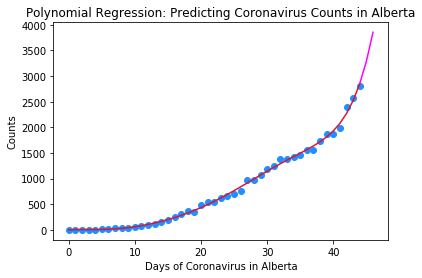

British Columbia Degree = 4


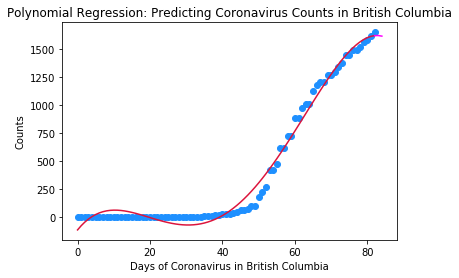

Manitoba Degree = 3


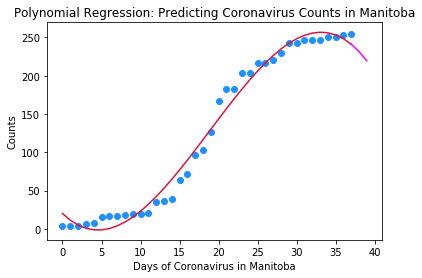

New Brunswick Degree = 8


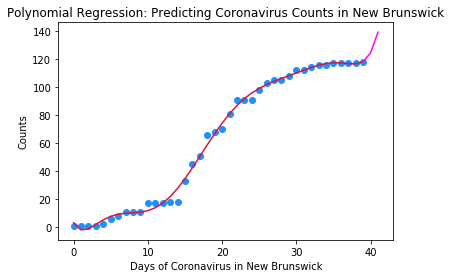

Newfoundland and Labrador Degree = 4


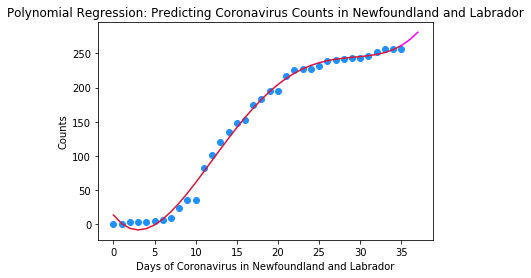

Nova Scotia Degree = 7


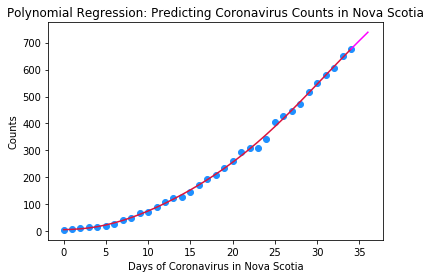

Ontario Degree = 5


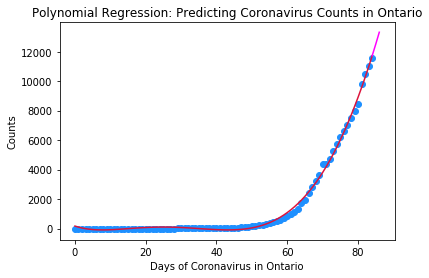

Prince Edward Island Degree = 4


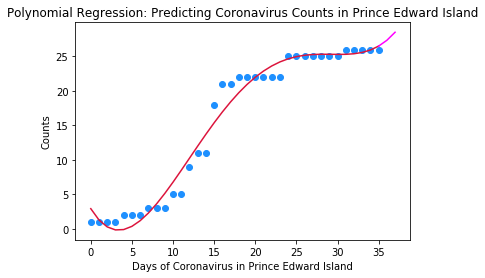

Quebec Degree = 7


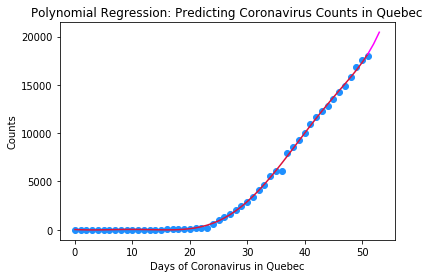

Saskatchewan Degree = 4


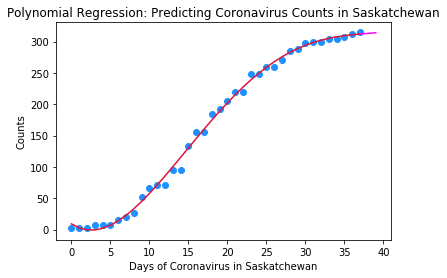

Canada Degree = 5


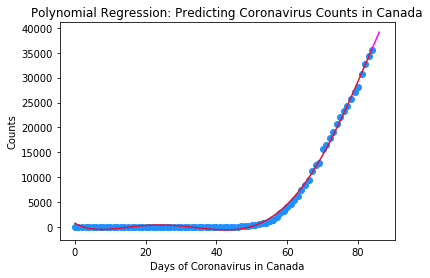

In [27]:
# Polynomial Regression for provinces below:
confirmed_predicts = {}
PolyReg_prediction(Province_list, confirmed_degrees)
confirmed_predicts.update(predictions)

In [28]:
# Print off all confirmed count predictions
confirmed_predicts

{'Alberta': array([2856., 3290., 3854.]),
 'British Columbia': array([1617., 1618., 1613.]),
 'Manitoba': array([241., 232., 219.]),
 'New Brunswick': array([118., 124., 139.]),
 'Newfoundland and Labrador': array([262., 270., 281.]),
 'Nova Scotia': array([676., 708., 739.]),
 'Ontario': array([11727., 12508., 13318.]),
 'Prince Edward Island': array([26., 27., 29.]),
 'Quebec': array([18187., 19215., 20444.]),
 'Saskatchewan': array([312., 313., 314.]),
 'Canada': array([35841., 37477., 39093.])}

## Predicting Next 3 days for Death Count (Polynomial Regression)

In [29]:
# # SVR code is unused since it does not perform as well as polynomial regression
# Death_SVR_Provinces = [deaths_Alberta, deaths_Ontario]
# SVR_prediction(Death_SVR_Provinces)
# death_predicts.update(predictions)

Alberta Degree = 4


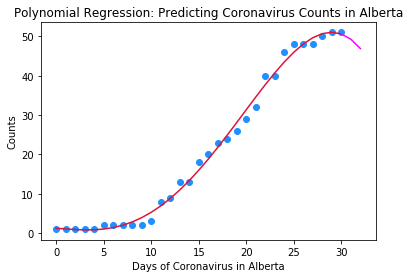

British Columbia Degree = 5


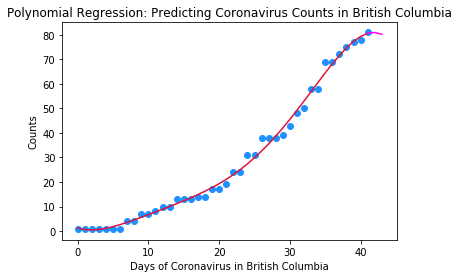

Manitoba Degree = 7


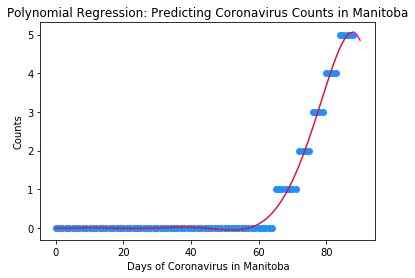

New Brunswick Degree = 1


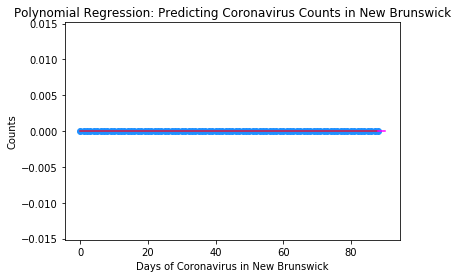

Newfoundland and Labrador Degree = 7


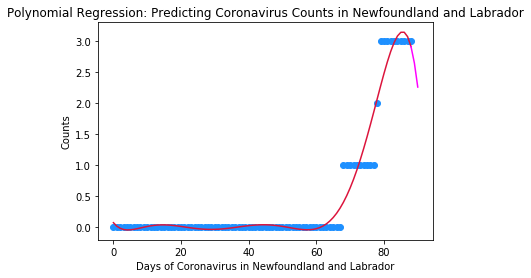

Nova Scotia Degree = 1


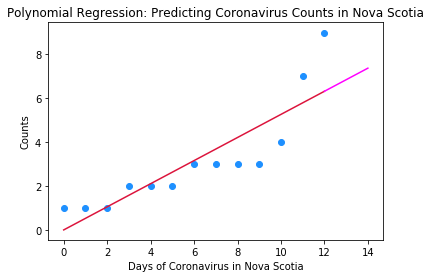

Ontario Degree = 3


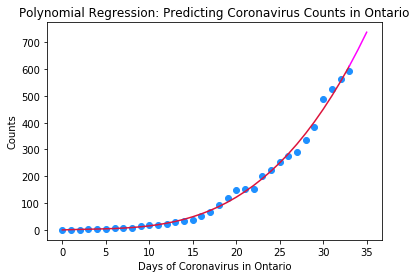

Prince Edward Island Degree = 1


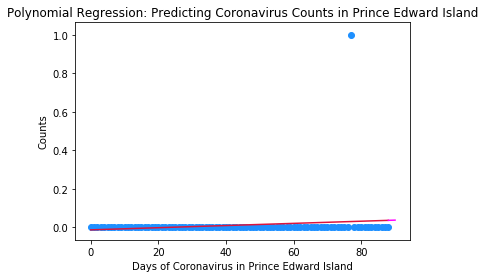

Quebec Degree = 3


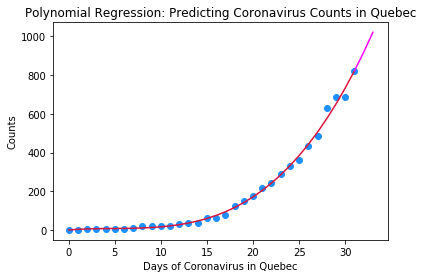

Saskatchewan Degree = 2


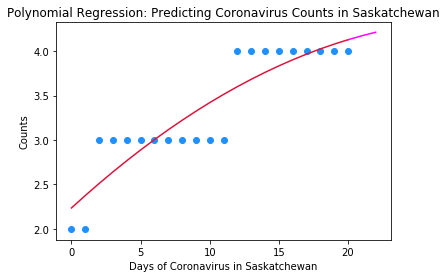

Canada Degree = 3


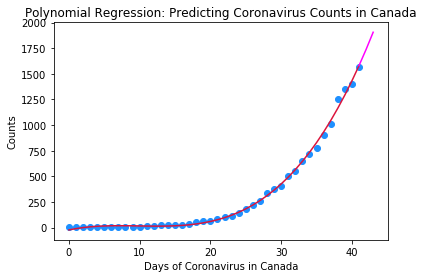

In [30]:
# Create a dictionary to hold predicted death counts for each province
death_predicts = {}

# Running Polynomial Regression predictions for death counts in selected provinces
PolyReg_prediction(Province_dlist, death_degrees)
death_predicts.update(predictions)

In [31]:
# Print prediction results for the provinces that were modelled
import pprint
pprint.pprint(death_predicts)

{'Alberta': array([51., 49., 47.]),
 'British Columbia': array([81., 81., 80.]),
 'Canada': array([1580., 1738., 1906.]),
 'Manitoba': array([5., 5., 5.]),
 'New Brunswick': array([0., 0., 0.]),
 'Newfoundland and Labrador': array([3., 3., 2.]),
 'Nova Scotia': array([6., 7., 7.]),
 'Ontario': array([611., 672., 737.]),
 'Prince Edward Island': array([0., 0., 0.]),
 'Quebec': array([ 822.,  919., 1022.]),
 'Saskatchewan': array([4., 4., 4.])}


Canada Degree = 6


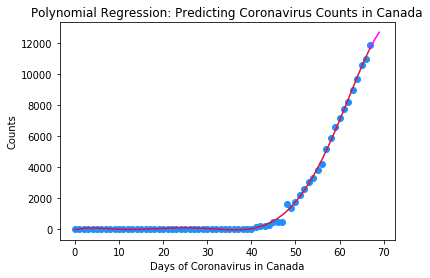

In [32]:
# For recovery, it was manually run and the best degree was found to be 6
# Hard coding this part
recovered_predicts = {}
PolyReg_prediction([recovered['Canada']], [6])
recovered_predicts.update(predictions)

In [33]:
# Order the index of the dataframe
order = ['Canada', 'Alberta', 'British Columbia', 'Manitoba', 'New Brunswick',
         'Newfoundland and Labrador', 'Nova Scotia', 'Ontario', 'Prince Edward Island',
         'Quebec', 'Saskatchewan']

# Convert dictionary predictions to a pandas dataframe
# Set the order and make it whole numbers
# Note that I am hard coding in the dates, its not necessarily april 20-22, but actually the next 3 days

confirmed_df = pd.DataFrame.from_dict(confirmed_predicts, orient = "index", 
                                      columns = ['April 20', 'April 21','April 22'])
confirmed_df = confirmed_df.reindex(order).astype(int)

death_df = pd.DataFrame.from_dict(death_predicts, orient = "index", 
                                  columns = ['April 20', 'April 21','April 22'])
death_df = death_df.reindex(order).dropna().astype(int)

recovered_df = pd.DataFrame.from_dict(recovered_predicts, orient = "index",
                                      columns = ['April 20', 'April 21','April 22']).astype(int)

# Final Dataframe for all 3 Datasets

In [34]:
confirmed_df

,April 20,April 21,April 22
Canada,35841,37477,39093
Alberta,2856,3290,3854
British Columbia,1617,1618,1613
Manitoba,241,232,219
New Brunswick,118,124,139
Newfoundland and Labrador,262,270,281
Nova Scotia,676,708,739
Ontario,11727,12508,13318
Prince Edward Island,26,27,29
Quebec,18187,19215,20444


In [35]:
death_df

,April 20,April 21,April 22
Canada,1580,1738,1906
Alberta,51,49,47
British Columbia,81,81,80
Manitoba,5,5,5
New Brunswick,0,0,0
Newfoundland and Labrador,3,3,2
Nova Scotia,6,7,7
Ontario,611,672,737
Prince Edward Island,0,0,0
Quebec,822,919,1022


In [36]:
recovered_df

,April 20,April 21,April 22
Canada,11706,12238,12688


In [37]:
# # Exporting all 3 dataframes to CSV
# confirmed_df.to_csv('confirmed_predicted.csv')
# death_df.to_csv('deaths_predicted.csv')
# recovered_df.to_csv('recovered_predicted.csv')

# <center> Overall Thoughts </center>

&nbsp;&nbsp; So it turns out that some days, SVR works better and some other days Polynomial Regression is a better model for certain provinces. Kind of interesting to see this change happens day-by-day, but it certainly surprised me to see how much change can occur in any given day. These univariate models are really supposed to be a stepping stone for further modelling techniques, as they can provide a pretty good base reference to compare results to. Ideally, it would be interesting to see some recurrent neural networks applied to this problem. However, it seems like we can get a general idea of how the predictions will look with simple regressions.

&nbsp;&nbsp; Looking at our predictions, we see that our model actually predicts a drop in confirmed cases and death cases for some provinces (Alberta death counts, Manitoba confirmed cases, etc). This is reasonable since our model doesn't have enough information to tell when the curve actually flattens. I kept the SVR model in so that it can be run in another day once we have more data. It'd be interesting to see which model turns out best at the end. 

# References

* [1] https://xgboost.readthedocs.io/en/latest/tutorials/model.html
* [2] https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-xgboost#Up-next?
* [3] https://stackoverflow.com/questions/47442102/how-to-find-the-best-degree-of-polynomials
